É preciso rodar, reiniciar e rodar novamente.

In [1]:
!pip install auto-sklearn
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1: Utilizando a base de dados [Higher Education Students Performance Evaluation](https://www.kaggle.com/datasets/csafrit2/higher-education-students-performance-evaluation), elabore uma solução para identificar a saída GRADE do estudante.

### a) Faça o pré-processamento dos dados (limpeza, engenharia de variáveis, etc). Utilize pelo menos uma forma de redimensionamento de atributos (selecionando ou agregando) e utilize ambas as amostras para avaliar os resultados.

In [2]:
from pandas import read_csv

df = read_csv("https://raw.githubusercontent.com/hyoretsu-cc-ufpb/ia/main/databases/student_prediction.csv")

classes = ["Fail", "DD", "DC", "CC", "CB", "BB", "BA", "AA"]

Retiramos colunas que não agregam à analise:

In [3]:
# Removendo colunas de identificação
df = df.drop(columns=["STUDENTID", "COURSE ID"])

Como todos os dados categóricos já foram convertidos em números, não precisamos fazer essa etapa:

In [4]:
df.dtypes

AGE              int64
GENDER           int64
HS_TYPE          int64
SCHOLARSHIP      int64
WORK             int64
ACTIVITY         int64
PARTNER          int64
SALARY           int64
TRANSPORT        int64
LIVING           int64
MOTHER_EDU       int64
FATHER_EDU       int64
#_SIBLINGS       int64
KIDS             int64
MOTHER_JOB       int64
FATHER_JOB       int64
STUDY_HRS        int64
READ_FREQ        int64
READ_FREQ_SCI    int64
ATTEND_DEPT      int64
IMPACT           int64
ATTEND           int64
PREP_STUDY       int64
PREP_EXAM        int64
NOTES            int64
LISTENS          int64
LIKES_DISCUSS    int64
CLASSROOM        int64
CUML_GPA         int64
EXP_GPA          int64
GRADE            int64
dtype: object

Tratamos possíveis dados defeituosos:

In [5]:
# Removendo dados duplicados
df = df.drop_duplicates()
# Removendo dados nulos
df = df.dropna()

Usamos correlação para identificar variáveis independentes que podem ser removidas:

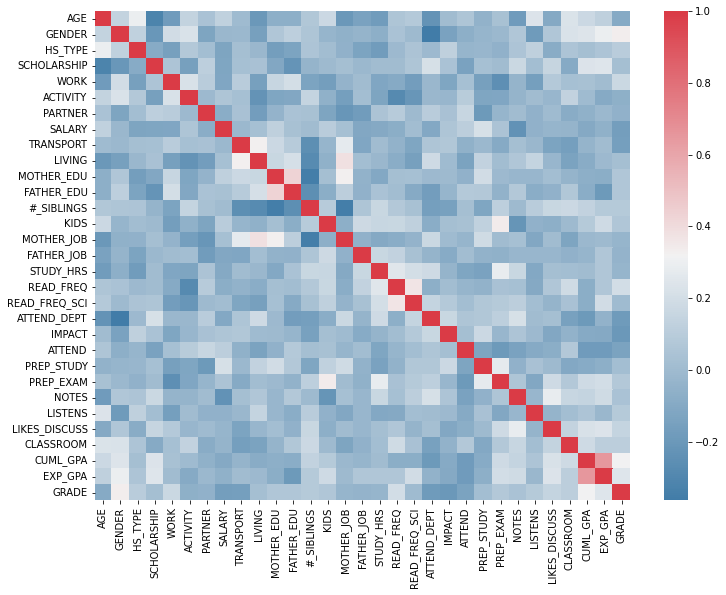

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), cmap=sns.diverging_palette(240, 10, as_cmap=True))
plt.show()

Considerando um nível alto de correlação como > 0.6, podemos remover o atributo "EXP_GPA" (que nada mais é do que uma previsão do CUML_GPA) em favor de "CUML_GPA".

In [7]:
import numpy as np
from pandas import DataFrame

def drop_correlation(dataset: DataFrame, threshold: int):
    # Create correlation matrix
    corr_matrix = dataset.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features
    return dataset.drop(to_drop, axis=1)


df_best = drop_correlation(df, 0.6)

Podemos reduzir ainda mais as variáveis juntando as 4 de pai e mãe (escolaridade e trabalho) em uma única de parentes, assim como as 2 sobre leitura de livros. Porém, na minha opinião, isso poderia acarretar numa possível perda de *insight*.

Ou, também, remover colunas com correlação insignificante (< 0.1), mas este caminho pode trazer efeitos adversos, como nos privar de uma variável possivelmente útil ou causar *overfitting*.

### b) Faça uma análise exploratória dos dados de saída, utilizando box plot, e aplique undersampling ou oversampling para balancear os dados caso preciso.

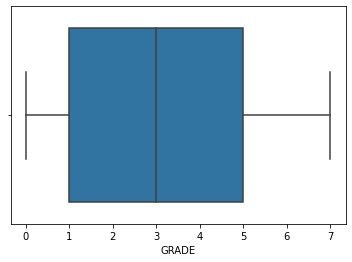

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x="GRADE", data=df)
plt.show()

Podemos notar uma diferença no tamanho das caudas, sem presença de outliers, e que a mediana não está no centro do gráfico. Isso nos mostra um forte desbalanceamento para os valores menores, portanto aplicaremos oversampling através da técnica "Synthetic Minority Over-sampling Technique" implementada pela biblioteca Imbalanced-learn:

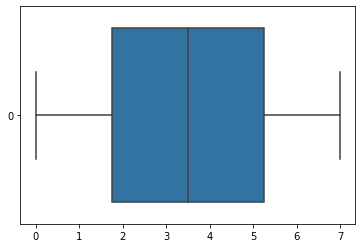

In [9]:
from imblearn.over_sampling import SMOTE

# [x, y]
df = [df.iloc[:, :-1], df.iloc[:, -1]]
# [x, y]
df_best = [df_best.iloc[:, :-1], df_best.iloc[:, -1]]

# rand=np.random.randint(1000)
# print(rand)

smote = SMOTE(random_state=603)
df = smote.fit_resample(df[0], df[1])
df_best = smote.fit_resample(df_best[0], df_best[1])

sns.boxplot(data=df_best[1], orient="horizontal")
plt.show()

Com isto, a mediana encontra-se devidamente no centro dos valores e as distâncias entre os percentils e as caudas estãos iguais, portanto as amostras foram balançeadas.

### c) Utilize a biblioteca AutoML para fazer a previsão, com validação cruzada estratificada 10-fold e "random_state" fixo. Identifique o algoritmo que teve o melhor resultado e avalie-o com 2 métricas de sua preferência e matriz de confusão.

In [10]:
from autosklearn.classification import AutoSklearnClassifier
from IPython.display import display
from pandas import DataFrame
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from warnings import simplefilter

simplefilter("ignore")

x_train, x_test, y_train, y_test = train_test_split(df[0], df[1], test_size=0.33, random_state=603, stratify=df[1])

automl = AutoSklearnClassifier(
    time_left_for_this_task=60 * 4,
    resampling_strategy="cv",
    resampling_strategy_arguments={"folds": 10},
    n_jobs=-1
)

automl.fit(x_train, y_train)
automl.refit(x_train, y_train)

AutoSklearnClassifier(n_jobs=-1, per_run_time_limit=48,
                      resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 10},
                      time_left_for_this_task=240)

Para analisar os resultados usaremos a acurácia, visto que as classes estão balanceadas, precisão e sensibilidade (Medida F1). Nota-se que não usaremos a média "micro" pois seus resultados são os mesmos da acurácia em amostras balanceadas.

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
results = automl.predict(x_test)

print(f"Acurácia: {accuracy_score(y_test, results)}")
print(f"Precisão: {precision_score(y_test, results, average='macro')}")
print(f"Sensibilidade: {recall_score(y_test, results, average='macro')}")
print(automl.leaderboard())

Acurácia: 0.7204301075268817
Precisão: 0.7469990079365079
Sensibilidade: 0.7196969696969697
          rank  ensemble_weight                type      cost   duration
model_id                                                                
7            1             0.24          libsvm_svc  0.374332  11.218150
13           2             0.22  passive_aggressive  0.411765  23.182669
15           3             0.08                 lda  0.422460  13.934443
5            4             0.02          libsvm_svc  0.443850  10.158857
10           5             0.22       random_forest  0.556150  35.319895
11           6             0.04                 mlp  0.561497  13.056973
4            7             0.18       random_forest  0.609626  22.700499


O melhor algoritmo encontrado foi o SVC (C-Support Vector Classification). Sua performance foi mediana, visto que conseguiu apenas 72% de acurácia. Com uma diferença significativa entre a precisão e a sensibilidade, o modelo se enganou menos do que falhou em prever corretamente as classes.

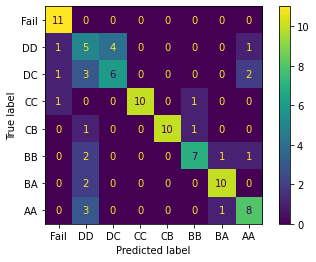

In [12]:
cm = confusion_matrix(y_test, results)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot()
plt.show()

A matriz de confusão nos dá uma visão mais clara do que aconteceu. Em metade das classes, a taxa de acerto foi muito boa, entre 80% e 100%. Ele teve um pouco de dificuldade nas classes "BB" e "AA" e bastante dificuldade nas classes "DD" e "DC", onde conseguiu apenas 45% e 50% de acurácia.

In [13]:
simplefilter("ignore")

x_train2, x_test2, y_train2, y_test2 = train_test_split(df_best[0], df_best[1], test_size=0.33, random_state=603, stratify=df_best[1])

automl2 = AutoSklearnClassifier(
    time_left_for_this_task=60 * 4,
    resampling_strategy="cv",
    resampling_strategy_arguments={"folds": 10},
    n_jobs=-1
)

automl2.fit(x_train2, y_train2)
automl2.refit(x_train2, y_train2)

AutoSklearnClassifier(n_jobs=-1, per_run_time_limit=48,
                      resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 10},
                      time_left_for_this_task=240)

In [14]:
results2 = automl2.predict(x_test2)

print(f"Acurácia: {accuracy_score(y_test2, results2)}")
print(f"Precisão: {precision_score(y_test2, results2, average='macro')}")
print(f"Sensibilidade: {recall_score(y_test2, results2, average='macro')}")
print(automl2.leaderboard())

Acurácia: 0.6666666666666666
Precisão: 0.6619682400932401
Sensibilidade: 0.6647727272727273
          rank  ensemble_weight                type      cost   duration
model_id                                                                
2            1             0.46       random_forest  0.331551  30.222223
7            2             0.08          libsvm_svc  0.401070  11.280466
13           3             0.04  passive_aggressive  0.417112  21.908839
6            4             0.02          libsvm_svc  0.438503   8.291333
15           5             0.22                 lda  0.438503  15.282149
3            6             0.02                 mlp  0.449198  24.674015
10           7             0.04       random_forest  0.524064  34.140495
4            8             0.10       random_forest  0.540107  22.678451
11           9             0.02                 mlp  0.556150  16.220151


Desta vez, desconsiderar variáveis independentes altamente correlacionadas entre si teve um efeito contrário ao esperado, diminuindo as métricas no geral. A acurácia caiu cerca de 5,5%.

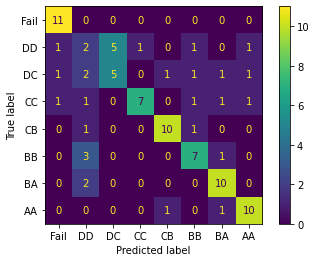

In [15]:
cm2 = confusion_matrix(y_test2, results2)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes).plot()
plt.show()

Seu resultado nas classes "DD" e "CC" piorou bastante, chegando a apenas 18% na "DD". Em "DC" piorou levemente e curiosamente teve um resultado melhor para a classe "AA". No geral, se saiu pior que o dataset completo.

Abaixo temos um relatório mais detalhado sobre os algoritmos que foram testados no 1º modelo:

In [16]:
report = DataFrame(automl.cv_results_).set_index("rank_test_scores").sort_values(by=["rank_test_scores"])

display(report)

,mean_test_score,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,param_data_preprocessor:__choice__,param_feature_preprocessor:__choice__,param_classifier:adaboost:algorithm,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
rank_test_scores,,,,,,,,,,,,,,,,,,,,,
1,0.625668,11.218150,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,libsvm_svc,feature_type,no_preprocessing,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.588235,23.182669,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,passive_aggressive,feature_type,polynomial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.577540,13.934443,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,lda,feature_type,polynomial,NaN,...,0.777883,0.185241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.572193,47.417785,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,mlp,feature_type,feature_agglomeration,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.556150,10.158857,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,libsvm_svc,feature_type,feature_agglomeration,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.443850,35.319895,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,random_forest,feature_type,feature_agglomeration,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.438503,13.056973,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,mlp,feature_type,liblinear_svc_preprocessor,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.390374,22.700499,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,random_forest,feature_type,feature_agglomeration,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.128342,12.165502,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,gradient_boosting,feature_type,select_percentile_classification,NaN,...,0.810188,0.236563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### d) Teste e avalie 3 variações dos hiperparâmetros do método encontrado anteriormente.

Dado que a biblioteca Auto-sklearn NÃO nos fornece uma maneira fácil de rodar métodos específicos ou sequer de recuperar os parâmetros usados, faremos uma cópia manual dos parâmetros para as questões posteriores.

Por este motivo, também, os resultados não são os mesmos quando o modelo é rodado pelo AutoML, pelo menos sem incluir outras etapas.

In [17]:
# Identificando hiperparâmetros do melhor algoritmo
bestParams = report.loc[1]["params"]

print(f"Parâmetros do melhor modelo encontrado pelo AutoML:\n{bestParams}")

origParams = {
    "C": 575.2840839820392,
    "gamma": 0.28251015893293174,
    "kernel": "rbf",
    "max_iter": -1,
    "shrinking": False,
    "tol": 6.314728575433805e-05
}

Parâmetros do melhor modelo encontrado pelo AutoML:
{'balancing:strategy': 'weighting', 'classifier:__choice__': 'libsvm_svc', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:libsvm_svc:C': 575.2840839820392, 'classifier:libsvm_svc:gamma': 0.28251015893293174, 'classifier:libsvm_svc:kernel': 'rbf', 'classifier:libsvm_svc:max_iter': -1, 'classifier:libsvm_svc:shrinking': 'False', 'classifier:libsvm_svc:tol': 6.314728575433805e-05, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'median', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'none'}


Para os testes, mudaremos o parâmetro "C".

In [18]:
from sklearn.svm import SVC

params = [origParams.copy(), origParams.copy(), origParams.copy()]

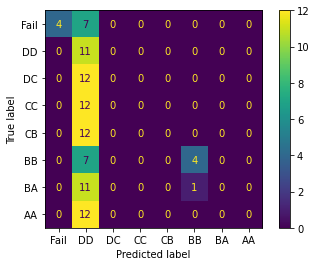

Acurácia: 0.20430107526881722
Precisão: 0.24136904761904762
Sensibilidade: 0.21590909090909094


In [19]:
params[0].update({"C": 0.1})

svc = SVC(**params[0])
svc.fit(x_train, y_train)
results = svc.predict(x_test)

cm3 = confusion_matrix(y_test, results)
ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=classes).plot()
plt.show()

print(f"Acurácia: {accuracy_score(y_test, results)}")
print(f"Precisão: {precision_score(y_test, results, average='macro')}")
print(f"Sensibilidade: {recall_score(y_test, results, average='macro')}")

Partindo de C próximos a 0, a acurácia é baixíssima. No teste feito, a IA simplesmente previu a grande maioria das instâncias como "CC". Pelo parâmetro "C" ser uma espécie de medida de penalização para previsões erradas, um valor pequeno não irá se importar muito em acertar ou não.

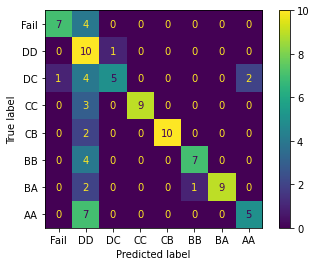

Acurácia: 0.6666666666666666
Precisão: 0.8219246031746033
Sensibilidade: 0.6685606060606061


In [20]:
params[1].update({"C": 1})

svc = SVC(**params[1])
svc.fit(x_train, y_train)
results = svc.predict(x_test)

cm3 = confusion_matrix(y_test, results)
ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=classes).plot()
plt.show()

print(f"Acurácia: {accuracy_score(y_test, results)}")
print(f"Precisão: {precision_score(y_test, results, average='macro')}")
print(f"Sensibilidade: {recall_score(y_test, results, average='macro')}")

A partir daí, a acurácia vai subindo gradualmente. Com C = 1, metade das classes (Fail, CC, BB e BA) estão razoáveis, algumas (DD e CB) estão muito boas, mas outras ainda continuam ruins. (DC e AA)

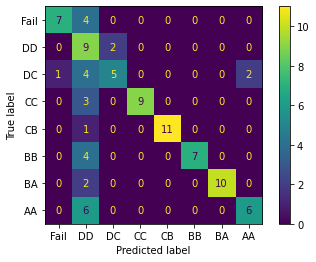

Acurácia: 0.6881720430107527
Precisão: 0.8265016233766234
Sensibilidade: 0.6884469696969697


In [21]:
params[2].update({"C": 2.7})

svc = SVC(**params[2])
svc.fit(x_train, y_train)
results = svc.predict(x_test)

cm3 = confusion_matrix(y_test, results)
ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=classes).plot()
plt.show()

print(f"Acurácia: {accuracy_score(y_test, results)}")
print(f"Precisão: {precision_score(y_test, results, average='macro')}")
print(f"Sensibilidade: {recall_score(y_test, results, average='macro')}")


E vai subindo gradualmente até chegar na região de máxima, quando o C está >= 2.7, evidenciando a existência de um C otimizado que garante o melhor resultado (para os parâmetros, base e random_state utilizados).

## 2: Utilizando a mesma base de dados da questão anterior, agrupe, avalie e compare, com uma métrica de avaliação, as instâncias utilizando os seguintes métodos de clusterização:

### a) k-means, com k = 5 e k = 7.

In [22]:
import pandas as pd
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.cluster import KMeans

x_cluster = pd.concat([x_train, x_test])
y_cluster = pd.concat([y_train, y_test])

kmeans5 = KMeans(n_clusters=5, random_state=603)
kmeans5.fit_predict(x_cluster)

# plt.scatter(x_cluster["CUML_GPA"], y_cluster, c=kmeans5.labels_)
# plt.scatter(kmeans5.cluster_centers_[:, 0], kmeans5.cluster_centers_[:, 1], s=200, color="red")
# plt.show()

print(f"Silhueta: {silhouette_score(x_cluster, kmeans5.labels_)}")
print(f"Completude: {homogeneity_score(y_cluster, kmeans5.labels_)}")

Silhueta: 0.10379467437300212
Completude: 0.14358707515809258


Com ambos silhueta e completude fracos, esse método não conseguiu separar muito bem os clusters nem separar um cluster para cada classe.

In [23]:
kmeans7 = KMeans(n_clusters=7, random_state=603)
kmeans7.fit_predict(x_cluster)

print(f"Silhueta: {silhouette_score(x_cluster, kmeans7.labels_)}")
print(f"Completude: {homogeneity_score(y_cluster, kmeans7.labels_)}")

Silhueta: 0.10795281831418005
Completude: 0.15817505978653387


Os resultados com k = 7 foram melhores, ainda que bem levemente, acredito que devido à amostra original ter 8 grupos.

### b) Hierárquico, para 5 e 7 grupos e com 2 tipos diferentes de linkage.

Serão usados os tipos de *linkage* "single", que considera a mínima distância entre 2 pontos de um cluster, e "ward", que considera a variância entre os clusters.

In [24]:
from sklearn.cluster import AgglomerativeClustering

hierarchical5single = AgglomerativeClustering(n_clusters=5, linkage="single")
hierarchical5single.fit_predict(x_cluster)

print(f"Silhueta: {silhouette_score(x_cluster, hierarchical5single.labels_)}")
print(f"Completude: {homogeneity_score(y_cluster, hierarchical5single.labels_)}")

Silhueta: 0.05891742617644548
Completude: 0.015573441434943809


Com 5 clusters, os resultados para o método hierárquico foram piores que o método k-means. Houve bem mais sobreposição e muitos clusters receberam outras classes além de sua "nominal".

In [25]:
hierarchical7single = AgglomerativeClustering(n_clusters=7, linkage="single")
hierarchical7single.fit_predict(x_cluster)

print(f"Silhueta: {silhouette_score(x_cluster, hierarchical7single.labels_)}")
print(f"Completude: {homogeneity_score(y_cluster, hierarchical7single.labels_)}")

Silhueta: 0.01996252075184436
Completude: 0.022794004426366362


Com 7 clusters, os resultados foram os piores até agora. Houeve cerca de 70% mais sobreposição do que com 5 clusters, apesar dele ter misturado menos classes nos mesmos clusters.

In [26]:
hierarchical5ward = AgglomerativeClustering(n_clusters=5, linkage="ward")
hierarchical5ward.fit_predict(x_cluster)

print(f"Silhueta: {silhouette_score(x_cluster, hierarchical5ward.labels_)}")
print(f"Completude: {homogeneity_score(y_cluster, hierarchical5ward.labels_)}")

Silhueta: 0.08443643245267653
Completude: 0.14731986385717535


In [27]:
hierarchical7ward = AgglomerativeClustering(n_clusters=7, linkage="ward")
hierarchical7ward.fit_predict(x_cluster)

print(f"Silhueta: {silhouette_score(x_cluster, hierarchical7ward.labels_)}")
print(f"Completude: {homogeneity_score(y_cluster, hierarchical7ward.labels_)}")

Silhueta: 0.08579078615306826
Completude: 0.18659413359784083


Ambos 5 e 7 clusters com *linkage* "ward" tiveram resultados melhores que "single", mas ainda piores que o k-means e longe de serem sequer aceitáveis. Neste caso também o teste com 7 clusters se provou mais bem-sucedido.

## 3: Quais são as vantagens e desvantagens de utilizar a biblioteca AutoML? Como você faria para usá-la, garantindo os melhores resultados possíveis?